## Packages

In [1]:
import pandas as pd
import json, requests 
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from tqdm import tqdm

import time

import unicodedata
#from metaphone import doublemetaphone
#from fuzzywuzzy import fuzz
from difflib import SequenceMatcher
import re


from math import radians, cos, sin, asin, sqrt

import datetime 
from datetime import date

import psycopg2


In [3]:
main_path = "/home/fs01/spec1142/Emma/PPPs/"

f = open(main_path + "database.txt", "r")
user , password = f.read().split()

In [4]:
dic_institutions = pd.read_csv(main_path + "institutions_up_to_20230817.tsv" , delimiter = "\t", index_col = 0).to_dict("index")

In [6]:
## import predictive model trained using self-plagiarism
import pickle
with open(main_path + 'random_forest_PPPs.pkl','rb') as f:
    rf = pickle.load(f)
    

## Functions 

In [7]:
def clean_encoding(encoded_text):
    if encoded_text == None:
        return None
    else:
        if "\n" in encoded_text:
            encoded_text = encoded_text.replace("\n" , "")
        encoded_text = encoded_text[1:-1]
        encoded_text = list(map(float , encoded_text.split()))
        return encoded_text

In [8]:
name_del = set(["2nd", "3rd", "Jr", "Jr.", "Junior", "Sr", "Sr.", "Senior"])
ln_suff= set(["oster", "nordre", "vaster", "aust", "vesle", "da", "van t", "af", "al", "setya", "zu", "la", "na", "mic", "ofver", "el", "vetle", "van het", "dos", "ui", "vest", "ab", "vste", "nord", "van der", "bin", "ibn", "war", "fitz", "alam", "di", "erch", "fetch", "nga", "ka", "soder", "lille", "upp", "ua", "te", "ni", "bint", "von und zu", "vast", "vestre", "over", "syd", "mac", "nin", "nic", "putri", "bet", "verch", "norr", "bath", "della", "van", "ben", "du", "stor", "das", "neder", "abu", "degli", "vre", "ait", "ny", "opp", "pour", "kil", "der", "oz",  "von", "at", "nedre", "van den", "setia", "ap", "gil", "myljom", "van de", "stre", "dele", "mck", "de", "mellom", "mhic", "binti", "ath", "binte", "snder", "sre", "ned", "ter", "bar", "le", "mala", "ost", "syndre", "sr", "bat", "sndre", "austre", "putra", "putera", "av", "lu", "vetch", "ver", "puteri", "mc", "tre", "st"])


#suppress all the unwanted suffixes from a string. 
#name_del file can be modified if more or less suffixes want to be suppressed 


def name_delete(string):
    for elmt in name_del:
        if f" {elmt}" in string:
            string =  string.replace(f" {elmt}","")
    return string


#merge the nobiliary particles with the last name
#ln_suff file can be modified if more or less nobiliary particles want to be suppressed
    
def ln_suff_merge(string):
    for suff in ln_suff:
        if f"{' ' + suff + ' '}" in string or string.startswith(f"{suff + ' '}"):
            print(suff)
            string =  string.replace(f"{suff + ' '}", suff.replace(" ",""))
    return string



In [9]:
#normalize a string dat that represents often a name. 

def normalize(data):
    normal = unicodedata.normalize('NFKD', data).encode('ASCII', 'ignore')
    val = normal.decode("utf-8")
    # delete unwanted elmt
    val = name_delete(val)
    # Lower case
    val = val.lower()
    # remove special characters
    val = re.sub('[^A-Za-z ]+', ' ', val)
    # remove multiple spaces
    val = re.sub(' +', ' ', val)
    # remove trailing spaces
    val = val.strip()
    return val

normalize("PIERRE De BEHRMAN")

'pierre de behrman'

In [10]:
## calculate efficiently the dot product between two vectors

def norm(vector):
    return sqrt(sum(x * x for x in vector))    

def cosine_similarity2(vec_a, vec_b):
    norm_a = norm(vec_a)
    norm_b = norm(vec_b)
        
        
    if norm_a == 0 or norm_b == 0 :
        return None 
    
    else:
        dot = sum(a * b for a, b in zip(vec_a, vec_b))
        return dot / (norm_a * norm_b)

In [11]:
#return a ratio of similarity of letters between two strings (to handle in the first names errors)

def match_ratio(string1,string2):
    return fuzz.ratio(string1, string2)


In [12]:
#return 4 if string1 and string2 are the same
#return 3 if string1 and string2 sound the same
#otherwise, return less

def metaphone(string1,string2):
    if string1==string2:
        return 4
    tuple1 = doublemetaphone(string1)
    tuple2 = doublemetaphone(string2)
    if tuple1[0] == tuple2[0]:
        return 3
    elif tuple1[0] == tuple2[1] or tuple1[1] == tuple2[0]:
        return 2
    elif tuple1[1] == tuple2[1]:
        return 1
    else:
        return 0

In [13]:
## return 1 if name1 and name2 potentially represent the same individual
## else return 0

def comparison(name1 , name2):
    
    #if there is no first name, retrun it's a match
    if name1 == "" or name2 == "":
        return 1
    
    #if some first names exist:
    list_name1 = name1.split()
    list_name2 = name2.split()
    
    #minimum number of first names to match
    number_match = min( len(list_name1) , len(list_name2))
    
    #for each name, check if there is a match
    count_match = 0
    for elem1 in list_name1:
        match = 0
        
        #if we just have the initial:
        if len(elem1) == 1:
            for elem2 in list_name2:
                if elem1[0] == elem2[0]:
                    match = 1
        else:
            for elem2 in list_name2:
                #if we just have the initial:
                if len(elem2) == 1 and elem1[0] == elem2[0]:
                    match = 1
                    
                #if elem1 and elem2 are entire first names that sound the same and have a ratio of common letters higher thsan 85%, it's a match
                elif len(elem2) > 1 and (metaphone(elem1,elem2) > 2 or match_ratio(elem1 , elem2) > 85 ) :
                    match = 1
                    
        #count the number of first names that match    
        count_match += match
        
    #check if we have enough first names that match 
    if count_match < number_match:
        return 0
    else:
        return 1



In [14]:
## get number of in common authors

def number_of_in_common_authors(inventors , authors ):
    

    
    #count the number of names in common, and store the names in common
    count = 0
    list_in_common_authors = []

    
    for name_inventor in inventors:
        
        for name_author in authors:
                        
            
            if len(set(name_inventor.split()) & set( name_author.split())) > 0:
            
                match = comparison(name_author , name_inventor)

                #if the first names match, we store the first names that are matching and their index 
                if match == 1:
                    count += 1 
                    list_in_common_authors.append(name_author + "-" + name_inventor)
                    


    #return 1) the number of names in common, 2) the list of names in common, 3) their index 
    return  count ,  list_in_common_authors 


In [15]:
## calculate efficiently the geographic distance between two points on the earth

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [16]:
def distance_assignees(coords1 , coords2):
     
    distance = np.inf
    #get minimum geographic distance between the paper and the patent institutions
    for elem1 in coords1:
        if elem1 in coords2:
            return 0
        else:
            for elem2 in coords2:
                dist = haversine(elem1[0], elem1[1], elem2[0], elem2[1])
                if dist < distance:
                    distance = dist
                    
    if distance == np.inf:
        distance = None
                    
    return distance
        

In [17]:
##function that compare a patent and a paper and create the features that will be used as input of the predictive model
def paper_patent_comparison(patent_id , paper_id , dic_comparison):

    
    ##the features are stored as a dictionay in the input dictonary
    dic_comparison["comparisons"][patent_id][paper_id] = {}
    
    ##compare the title and the abstract with by taking the cosinus of the numerical representations of the text
    title_OA = dic_comparison["OA"][paper_id]["title"]
    title_PV = dic_comparison["PV"][patent_id]["title"]
    abstract_OA = dic_comparison["OA"][paper_id]["abstract"]
    abstract_PV = dic_comparison["PV"][patent_id]["abstract"]
    
    if title_OA != None and title_PV != None:
        dic_comparison["comparisons"][patent_id][paper_id]["title_similarity"] = cosine_similarity2( title_OA , title_PV ) 
    else:
        dic_comparison["comparisons"][patent_id][paper_id]["title_similarity"] = None
        
    if abstract_PV != None and abstract_OA != None:
        dic_comparison["comparisons"][patent_id][paper_id]["abstract_similarity"] = cosine_similarity2( abstract_PV , abstract_OA ) 
    else:
        dic_comparison["comparisons"][patent_id][paper_id]["abstract_similarity"] = None
        
        
    ##calucate the difference (in days) between the patent grant date and the paper publication date
    if   dic_comparison["OA"][paper_id]["publication_date"] != None and dic_comparison["PV"][patent_id]["patent_date"] != None and dic_comparison["PV"][patent_id]["patent_date"]!= '':
        dic_comparison["comparisons"][patent_id][paper_id]["difference_patent_grant_paper"] =   (dic_comparison["PV"][patent_id]["patent_date"] - dic_comparison["OA"][paper_id]["publication_date"] ).days
        
    else:
        dic_comparison["comparisons"][patent_id][paper_id]["difference_patent_grant_paper"] = None
     
    
    ##calucate the difference (in days) between the patent application date and the paper publication date
    if dic_comparison["OA"][paper_id]["publication_date"] != None and dic_comparison["PV"][patent_id]["filing_date"] != None:
        dic_comparison["comparisons"][patent_id][paper_id]["difference_patent_app_paper"] =  (dic_comparison["PV"][patent_id]["filing_date"] - dic_comparison["OA"][paper_id]["publication_date"]).days
    else:
        dic_comparison["comparisons"][patent_id][paper_id]["difference_patent_app_paper"] = None
        
        
        
    ##store the paper's type (article, book-chapter etc...) 
    dic_comparison["comparisons"][patent_id][paper_id]["paper type"] = dic_comparison["OA"][paper_id]["type"]  
    
    ##count the number of author's name in common between the paper and the patent 
    dic_comparison["comparisons"][patent_id][paper_id]["authors in common"] = number_of_in_common_authors(dic_comparison["PV"][patent_id]["co_inventors"] , dic_comparison["OA"][paper_id]["co_authors"])[0]
    
    ##calculate what proportion of the patent inventors the number of author's name in common represents 
    dic_comparison["comparisons"][patent_id][paper_id]["proportion inventors"] = 100*number_of_in_common_authors(dic_comparison["PV"][patent_id]["co_inventors"] , dic_comparison["OA"][paper_id]["co_authors"])[0] / len(dic_comparison["PV"][patent_id]["co_inventors"])
    
    ##calculate the (minimal) geographic distance between the patent assignee and the paper institution (in km)
    dic_comparison["comparisons"][patent_id][paper_id]["distance_inst_assignee"] = distance_assignees(dic_comparison["PV"][patent_id]["coordinates"], dic_comparison["OA"][paper_id]["coordinates"] )
  
    ##return the updated dic_comparison
    return dic_comparison
        
        


## PPPs - generate citation based PPPs

In [30]:
#establishing the connection
conn = psycopg2.connect("user=" + user + " password=" + password) 

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

text = """ SELECT  patent_id, work_id
           FROM non_patent_citations_matt_marx
           WHERE SUBSTRING(patent_id , 1 , 2) = 'us' AND self = 'isself'
           ;"""

cursor.execute(text)
patent_paper_citations = cursor.fetchall()


conn.close()

In [31]:
len(patent_paper_citations)

1693202

In [22]:
def PPPs_citations(i):
    
    #establishing the connection
    conn = psycopg2.connect("user=" + user + " password=" + password) 
    #Creating a cursor object using the cursor() method
    cursor = conn.cursor()
        
    ##new output file: will store the potential PPPs. 
    dic_features = {}
    
    ##count the number of iteration realized - dic_features will be saved at 5000 iterations 
    k = 0
    index = [ k for k in range(i , len(patent_paper_citations) , 32) ][:1000]
    index = [0]
    for count in index:
        
        
        k += 1 
    
        elem = patent_paper_citations[count]
        paper_id , patent_id = [ "US-9453047" , "W1974244813"]
        paper_id  = elem[1]
        patent_id = elem[0].split("-")[1]

        print(paper_id,patent_id)
        
        ##dic_comparison stores all the papers (key: "OA"), patents data (key: "PV") and comparison between papers and patents ("comparisons")  corresponding the gatekeeper
        dic_comparison = {}
        dic_comparison["PV"] = {}
        dic_comparison["OA"] = {}
        dic_comparison["comparisons"] = {}
        ##query the patents data, and store the data in dic_comparison["PV"]
        dic_comparison_new = {}
        
        text = """ SELECT   p.patent_date , 
                            ap.filing_date , 
                            string_agg( CONCAT(disambig_inventor_name_first , ' ' , disambig_inventor_name_last  ) , '#') , 
                            pe.encoded_title , 
                            pe.encoded_abstract , 
                            string_agg( CONCAT(a.disambig_assignee_organization  , '%' , l.longitude , '%' , l.latitude)  , '#')
                    FROM patents_PatentsView AS p 
                    JOIN applications_PatentsView AS ap ON ap.patent_id = p.patent_id
                    JOIN inventors_PatentsView AS i ON i.patent_id =  p.patent_id
                    JOIN assignees_PatentsView AS a ON a.patent_id =  p.patent_id
                    JOIN locations_PatentsView AS l ON a.location_id = l.location_id
                    JOIN encoded_patents_PatentsView AS pe ON pe.patent_id = p.patent_id
                    WHERE p.patent_id = '""" + patent_id  + """'
                    GROUP BY p.patent_date , 
                            ap.filing_date , 
                            pe.encoded_title , 
                            pe.encoded_abstract ;"""
                
        cursor.execute(text)
        res = cursor.fetchall()
        
        for line in res:
            dic_comparison_new["patent_date"] = line[0]
            dic_comparison_new["filing_date"] = line[1]
            dic_comparison_new["co_inventors"] = [ normalize(elem) for elem in set(line[2].split("#")) ] 
            if line[0] != 0:
                dic_comparison_new["title"] = clean_encoding(line[3])
            if line[1] != 0:
                dic_comparison_new["abstract"] = clean_encoding(line[4])
            if line[5] != None:
                locations = [ elem.split("%") for elem in set(line[5].split("#"))] 
                dic_comparison_new["assignees"] = ", ".join([ elem[0] for elem in locations])
                dic_comparison_new["coordinates"] = [ (float(elem[1]) , float(elem[2]))for elem in locations if len(elem) > 2 ]
            else:
                dic_comparison_new["assignees"] = None
                dic_comparison_new["coordinates"] = []
        dic_comparison["PV"][patent_id] = dic_comparison_new
        
        ##query papers data and store the data in dic_comparison["OA"]
        dic_comparison_new = {}
        text = """ SELECT   we.encoded_title , 
                    we.encoded_abstract , 
                    w.publication_date , 
                    w.type , 
                    string_agg(a.display_name , '#') , 
                    string_agg(wa.institution_name , '#') , 
                    string_agg(wa.institution_id , '#')
           FROM works_authors_OpenAlex AS wa
           JOIN works_OpenAlex AS w ON w.work_id = wa.work_id
           JOIN authors_OpenAlex AS a ON wa.author_id = a.author_id
           JOIN encoded_works_OpenAlex AS we ON we.work_id = wa.work_id
           WHERE wa.work_id =  '""" + paper_id + """'
           GROUP BY we.encoded_title , 
                    we.encoded_abstract , 
                    w.publication_date , 
                    w.type;"""
        
        cursor.execute(text)
        res = cursor.fetchall()
        
        for line in res:
            try:
                dic_comparison_new["title"]  = clean_encoding(line[0])
            except: 
                dic_comparison_new["title"] = None
            try: 
                dic_comparison_new["abstract"]  = clean_encoding(line[1])
            except: 
                dic_comparison_new["abstract"] = None
            dic_comparison_new["publication_date"] = line[2]
            dic_comparison_new["type"] = line[3]
            dic_comparison_new["co_authors"] = [ normalize(elem) for elem in set(line[4].split("#") )] 
    
            dic_comparison_new["institutions"] = set()
            if line[5] != None:
                dic_comparison_new["institutions"] = set( line[5].split("#") )
                
            if line[6] != None:
                inst_ids = set(line[6].split("#"))
            else:
                inst_ids = []
                
            dic_comparison_new["coordinates"] = []
            for inst_id in inst_ids:
                    if inst_id in dic_institutions:
                        dic_comparison_new["coordinates"].append((dic_institutions[inst_id]["longitude"] , dic_institutions[inst_id]["latitude"]))
                        dic_comparison_new["institutions"].union(dic_institutions[inst_id]["display_name"])
            dic_comparison_new["institutions"] = "; ".join(list(dic_comparison_new["institutions"]))
    
        
        dic_comparison["OA"][paper_id]  = dic_comparison_new
        ##compare all the patents and papers together
        dic_comparison["comparisons"][patent_id] = {}
        ##compare patent_id with paper_id
        if dic_comparison["OA"][paper_id] != {} and dic_comparison["PV"][patent_id] != {}:
            dic_comparison = paper_patent_comparison(patent_id , paper_id , dic_comparison)
            table = pd.DataFrame(dic_comparison["comparisons"][patent_id]).T[['title_similarity', 'abstract_similarity', 'authors in common', 'proportion inventors','distance_inst_assignee']]
            
            ##if the distance is missing (if the assignee or institution location is missing) 
            ##replace the missing value with the average distance between the papers and the patents
            mean = table["distance_inst_assignee"].mean()
            table["distance_inst_assignee"] = table["distance_inst_assignee"].fillna(mean)
            
            ##drop all the papers and patents comparison with missing values (abstract, title, etc...)
            table = table.dropna()
            
            ##predict if the patents and papers are PPPs
            if len(table) > 0:
    
                table["predictions"] = rf.predict_proba(table)[:,1]
                
                ##keep only keep the prediction higher than 0.2 and the highest prediction (with a precision of 0.05)
                max_pred = max(table["predictions"])
                PPPs_paper_ids = table[ ( table["predictions"] > max_pred - 0.05 ) &  ( table["predictions"] > 0.7 )][["predictions"]].to_dict("index")
                
                ##write the selected PPPs in the output file dic_features 
                for paper_id in PPPs_paper_ids:
                        dic_features[paper_id + " US-" + patent_id] = dic_comparison["comparisons"][patent_id][paper_id]
                        dic_features[paper_id + " US-" + patent_id]["paper_id"] = paper_id
                        dic_features[paper_id + " US-" + patent_id]["patent_id"] = patent_id
                        dic_features[paper_id + " US-" + patent_id]["prediction"] = PPPs_paper_ids[paper_id]["predictions"]
    #Closing the connection
    conn.close() 

    ##save the output every 5000 iterations.
    if k % 5000 == 0:

        res = pd.DataFrame(dic_features).T
        res.to_csv(main_path + "PPPs_citations/table_pred_" + str(i) + ".tsv"  , sep = "\t")


    
    ##save the file as a tsv file
    res = pd.DataFrame(dic_features).T
    res.to_csv(main_path + "PPPs_citations/table_pred_" + str(i) + ".tsv" , sep = "\t" )

    
    
    return res
    



In [34]:
#run the code using 32 CPUs   
import warnings    
from multiprocessing import Process

if __name__ == '__main__':
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",UserWarning)
        
        processes = [Process(target=PPPs_citations, args=(k,)) for k in range(32)]
        
        for process in processes:
            process.start()
            
        for process in processes:
            process.join()

## Results

#### Load PPPs

res = pd.concat( [ pd.read_csv(main_path + "PPPs_citations/table_pred_" + str(i) + ".tsv"  , delimiter = "\t", index_col = 0  ) for i in range(64) ]) 


res.to_csv(main_path + "PPPs_citations/table_pred.tsv"  , sep = "\t" ) 

In [26]:
res = pd.read_csv(main_path + "PPPs_citations/table_pred.tsv" , delimiter = "\t" , index_col = 0  )

In [27]:
res = res[res["prediction"] > 0.7]
res = res.drop_duplicates(["paper_id" , "patent_id"])

In [28]:
res

,title_similarity,abstract_similarity,difference_patent_grant_paper,difference_patent_app_paper,paper type,authors in common,proportion inventors,distance_inst_assignee,paper_id,patent_id,prediction
W1638578210 US-7723760,0.346044,0.785618,3066,2129,article,4,80.000000,3.409587,W1638578210,7723760,1.000000
W1690808039 US-6136598,0.537028,0.697637,1698,798,article,3,100.000000,2.609515,W1690808039,6136598,0.967500
W1673923490 US-11416745,0.704467,0.440784,3160,2162,article,2,100.000000,3.733135,W1673923490,11416745,0.766178
W1670498114 US-10758556,0.626703,0.723126,1889,1497,article,2,66.666667,2.379905,W1670498114,10758556,0.996000
W1671485497 US-5180813,0.818046,0.656677,5619,4222,article,1,100.000000,2.086435,W1671485497,5180813,0.955887
...,...,...,...,...,...,...,...,...,...,...,...
W1618227575 US-7067815,0.533788,0.510171,2122,165,article,5,100.000000,52.257799,W1618227575,7067815,0.772131
W1626398438 US-8612134,0.436250,0.800919,1295,-98,article,2,66.666667,3.318669,W1626398438,8612134,1.000000
W1628806793 US-5663065,0.849975,0.765384,1189,366,article,3,100.000000,0.570003,W1628806793,5663065,0.987917
W1636622863 US-7179448,0.758577,0.500629,2425,1859,article,4,100.000000,1.275918,W1636622863,7179448,0.934667


#### PPP score

In [29]:
res["PPP_score"] = [ 4 if elem > 0.99 else 3 if elem > 0.9 else 2 if elem > 0.8 else 1 for elem in res["prediction"] ] 

#### Concepts and Paper institutions and types

In [108]:
import re 

print(len( set(res["paper_id"].tolist())))

list_papers_id = list(set(res["paper_id"].tolist()))

def get_dates(i):
    
    list_papers = [ k for k in range(0 + i , len(list_papers_id) , 64 ) ]

    dic_dates_papers = {}

    #establishing the connection
    conn = psycopg2.connect("user=" + user + " password=" + password) 
    #Creating a cursor object using the cursor() method
    cursor = conn.cursor()

    for k in list_papers: 
        
        paper = list_papers_id[k]
        
        if paper not in dic_dates_papers:
            dic_dates_papers[paper] = {}
            dic_dates_papers[paper]["institutions"] = set()
            dic_dates_papers[paper]["institution_name"] = set()
            dic_dates_papers[paper]["co_authors"] = []
        

        text = """ SELECT w.publication_date , w.concepts , string_agg(wa.institution_id, ',') , string_agg(wa.author_id , ',') , string_agg(wa.institution_name , '#')
                   FROM works_OpenAlex AS w
                   JOIN works_authors_OpenAlex AS wa ON wa.work_id = '""" + str(paper) + """'
                   WHERE w.work_id = '""" + str(paper) + """'
                   GROUP BY w.work_id , w.publication_date , w.concepts ;
                """

        cursor.execute(text)
        res = cursor.fetchall()
        
        
        if len(res) > 0:
            line = res[0]
            if line[0] != None:
                dic_dates_papers[paper]["publication_date"] = line[0].strftime("%m-%d-%y")
            else:
                dic_dates_papers[paper]["publication_date"] = None
                
            if line[1] != None:
                dic_dates_papers[paper]["concepts"] = line[1].split("; ")
            else:
                dic_dates_papers[paper]["concepts"] = []

            if line[2] != None:
                dic_dates_papers[paper]["institutions"] = list(set(line[2].split(",")))
            else:
                dic_dates_papers[paper]["institutions"]  = []

            if line[3] != None:
                dic_dates_papers[paper]["co_authors"] = list(set(line[3].split(",")))

            
            dic_dates_papers[paper]["institution_name"] = set()
            
            if line[4] != None:
                dic_dates_papers[paper]["institution_name"].add(set(line[4].split("#")))

            for inst in dic_dates_papers[paper]["institutions"]:
                if inst in dic_institutions:
                    dic_dates_papers[paper]["institution_name"].add(dic_institutions[inst]["display_name"])

            dic_dates_papers[paper]["institution_name"]  = list( dic_dates_papers[paper]["institution_name"] )

    conn.close() 

            
    import json
    json = json.dumps(dic_dates_papers)
    f = open(main_path + "PPPs_citations/dic_dates_" + str(i) + ".json","w")
    f.write(json)
    f.close()


    
    


import warnings

        
from multiprocessing import Process


if __name__ == '__main__':
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",UserWarning)
        
        processes = [Process(target=get_dates, args=(k,)) for k in range(64)]
        
        for process in processes:
            process.start()
            
        for process in processes:
            process.join()
            
       

69254


In [109]:
dic_dates = {}

for i in range(64):
    
    f = open(main_path + "PPPs_citations/dic_dates_" + str(i) + ".json","r")
    import json
    dic = json.load(f)
    
    dic_dates = { **dic_dates , **dic } 
    

print(len(dic_dates))

69254


In [110]:
import json
json = json.dumps(dic_dates)
f = open(main_path + "PPPs_citations/dic_dates.json","w")
f.write(json)
f.close()


In [30]:
f = open(main_path + "PPPs_citations/dic_dates.json","r")
import json
dic_dates = json.load(f)

In [31]:
res = res.drop_duplicates(["paper_id" , "patent_id"])
dic_PPPs = res.to_dict("index")

ww_institutions = pd.read_csv(main_path + "institutions_up_to_20230817.tsv" , delimiter = "\t" , index_col = 0 )
dic_ww_institutions = ww_institutions.to_dict("index")

main_concepts = set(['Computer science',
 'Medicine',
 'Biology',
 'Physics',
 'Political science',
 'Chemistry',
 'Philosophy',
 'Engineering',
 'Mathematics',
 'Psychology',
 'Materials science',
 'Art',
 'Geography',
 'Business',
 'Sociology',
 'Economics',
 'Geology',
 'History',
 'Environmental science'])

for count in tqdm(list(dic_PPPs.keys())):
    
    paper_id = dic_PPPs[count]["paper_id"]
    if "concepts" in dic_dates[paper_id]:
        concepts = list(set(dic_dates[paper_id]["concepts"]) & main_concepts)
        dic_PPPs[count]["concepts"] = ", ".join(concepts)
    if "institutions" in dic_dates[paper_id]:
        institutions = list(set(dic_dates[paper_id]["institution_name"]))
        dic_PPPs[count]["paper_institution"] = "; ".join(institutions)
        
        types = set()
        for string_inst in dic_dates[paper_id]["institutions"]:
            inst = string_inst.split("#tab#")
            for institution_id in inst:
                if institution_id in dic_ww_institutions:
                    data = dic_ww_institutions[institution_id]
                    if pd.isna(data["type"]) == False and data["type"] != None and data["type"] != 'nan':
                        types.add(data["type"])
        
        dic_PPPs[count]["paper_institutions"] = "; ".join(types)

    
res = pd.DataFrame(dic_PPPs).T   
    

100%|████████████████████████████████| 112092/112092 [00:01<00:00, 77114.11it/s]


#### Patent assignees and types

In [32]:
families = pd.read_csv(main_path + "patent_families.tsv" , delimiter = "\t" , index_col = 0 ) 
dic_patents_families = families.to_dict("index")

In [33]:
workers= 28

PPPs= pd.DataFrame(dic_PPPs).T 

def get_assignee_and_types(i):

    dic_patents = {}

    patents = list(set(PPPs["patent_id"].tolist()))

    index_patents = [ k for k in range(i,len(patents),workers)]
    
    #establishing the connection
    conn = psycopg2.connect("user=" + user + " password=" + password) 
    #Creating a cursor object using the cursor() method
    cursor = conn.cursor()


    for k in index_patents:
        
        patent_id = patents[k]

        dic_patents[patent_id] = {}

        dic_patents[patent_id]["type"] = []
        dic_patents[patent_id]["assignee"] = []


        text = """SELECT a.psn_sector , a.han_name
                  FROM ( select publn_nr , appln_id, publn_auth from patent_numbers_Patstat where publn_auth = 'US') AS n
                  JOIN patent_numbers_assignees_Patstat AS p ON p.appln_id = n.appln_id
                  JOIN assignees_PATSTAT AS a ON a.person_id = p.person_id
                  WHERE n.publn_nr = '""" + str(patent_id) + """' 
                  ;"""

        cursor.execute(text)
        res = cursor.fetchall()

        for line in res:

            if line[0] != None and line[0] != '' and line[0] != "INDIVIDUAL" and line[0] != "UNKNOWN":

                dic_patents[patent_id]["type"].append(line[0])
                dic_patents[patent_id]["assignee"].append(line[1])

        
        dic_patents[patent_id]["type"] = "; ".join(list(set(dic_patents[patent_id]["type"])))
        dic_patents[patent_id]["assignee"] = "; ".join(list(set(dic_patents[patent_id]["assignee"])))
        
        dic_patents[patent_id]["assignee_name"] = []
        
        text = """ SELECT disambig_assignee_organization , disambig_assignee_individual_name_last , disambig_assignee_individual_name_first
                    FROM assignees_PatentsView 
                    WHERE patent_id = '""" + str(patent_id) + """';
                    """

        cursor.execute(text)
        res = cursor.fetchall()
        
        for line in res:
            if line[0].replace('"' , '') != '':
                dic_patents[patent_id]["assignee_name"].append(line[0].replace('"' , ''))
            if line[1].replace('"' , '') != '' or line[2].replace('"' , '') :
                dic_patents[patent_id]["assigned_to_individual"] = 1

        
        dic_patents[patent_id]["assignee_name"] = "; ".join(dic_patents[patent_id]["assignee_name"])

        
        text = """ SELECT application_id
                       FROM applications_PatentsView AS a
                       WHERE patent_id = '""" + str(patent_id) + """';
                       """

        cursor.execute(text)
        res = cursor.fetchall()

        for line in res:

            application_number = line[0]

            if application_number in dic_patents_families:
                family = dic_patents_families[application_number]
                dic_patents[patent_id]["oldest_date"] = family["oldest_date"]
                dic_patents[patent_id]["family"] = family["family"]
            else:
                dic_patents[patent_id]["oldest_date"] = None
                dic_patents[patent_id]["family"] = None



    table = pd.DataFrame(dic_patents).T
    table.to_csv(main_path + "PPPs_citations/assignee_PV_PPPs_" + str(i) + ".tsv" , sep = "\t")

    conn.close() 

    return table


In [34]:
import warnings

        
from multiprocessing import Process


if __name__ == '__main__':
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",UserWarning)
        
        processes = [Process(target=get_assignee_and_types, args=(k,)) for k in range(28)]
        
        for process in processes:
            process.start()
            
        for process in processes:
            process.join()
            
            


In [35]:
table_assignees = pd.concat( [ pd.read_csv( main_path + "PPPs_citations/assignee_PV_PPPs_" + str(i) + ".tsv" , delimiter = "\t" , index_col = 0 ) for i in range(28) ] ) 
                              

In [36]:
table_assignees.to_csv( main_path + "PPPs_citations/assignee_PV_PPPs.tsv" , sep = "\t")

In [37]:
table_assignees = pd.read_csv( main_path +  "PPPs_citations/assignee_PV_PPPs.tsv" , delimiter = "\t", index_col = 0 )


In [38]:
PPPs= pd.DataFrame(dic_PPPs).T 
PPPs = PPPs.merge(table_assignees[['type', 'assignee_name', 'assigned_to_individual','oldest_date','family']] , left_on = "patent_id" , right_index = True, how = "left")
PPPs["assigned_to_individual"]  = PPPs["assigned_to_individual"].fillna(0)
PPPs = PPPs.rename( { "type" : "patent_institutions" , "assignee_name" : "patent_assignee"})
PPPs = PPPs.drop_duplicates()

#### Original parents

In [39]:
dic_PPPs = PPPs.to_dict("index")

count = 0
for elem in tqdm(dic_PPPs):
    patent = str(dic_PPPs[elem]["patent_id"])
    paper = dic_PPPs[elem]["paper_id"]
    
    if "publication_date" in dic_dates[paper] and pd.isna(dic_PPPs[elem]["oldest_date"])== False:
        count += 1
        dic_PPPs[elem]["difference_original_patent_app_paper"] = ( datetime.datetime.strptime(dic_PPPs[elem]["oldest_date"], "%Y-%m-%d") - datetime.datetime.strptime(dic_dates[paper]["publication_date"], "%m-%d-%y") ).days 
        
    else:
        dic_PPPs[elem]["difference_original_patent_app_paper"] = dic_PPPs[elem]["difference_patent_app_paper"]
        

PPPs = pd.DataFrame(dic_PPPs).T

PPPs["difference_original_patent_app_paper"] = PPPs["difference_original_patent_app_paper"].astype("int")
PPPs["difference_patent_app_paper"] = PPPs["difference_patent_app_paper"].astype("int")

PPPs = PPPs[( PPPs["difference_original_patent_app_paper"] < 3000 ) &  (PPPs["difference_original_patent_app_paper"] > -3000)]

100%|████████████████████████████████| 112092/112092 [00:02<00:00, 50791.84it/s]


#### all_patents_for_a_same_paper

In [66]:
import warnings

warnings.filterwarnings("ignore")

dic_same_patents = {} 

from collections import Counter
mylist = [ elem.split()[0] for elem in PPPs.index]
cnt = Counter(mylist)
list_papers = [k for k, v in cnt.items() if v > 1]




def get_similar_patents(i):

    count = 0 
    list_index = [ k for k in range(i,len(list_papers) , 28)]

    
    for k in list_index:
        
        paper_id = list_papers[k]
        matches = PPPs[PPPs["paper_id"] == paper_id]
        
        
        parents = set(matches["family"].tolist())
        if len(parents) == 1  and pd.isna(list(parents)[0]) == False:
            for elem in matches.index:
                if elem not in dic_same_patents:
                    dic_same_patents[elem] = {} 
                    count += 1
                    #PPPs["all_patents_for_a_same_paper"][elem] = "same parent"
                    dic_same_patents[elem]["all_patents_for_a_same_paper"]  = "same parent"
        
        if len(set(matches["difference_patent_app_paper"].tolist())) == 1:
            for elem in matches.index:
                if elem not in dic_same_patents:
                    dic_same_patents[elem] = {} 
                    count += 1
                    #PPPs["all_patents_for_a_same_paper"][elem] = "same application date"
                    dic_same_patents[elem]["all_patents_for_a_same_paper"] =  "same application date"
                else:
                    #PPPs["all_patents_for_a_same_paper"][elem] += ", same application date"
                    dic_same_patents[elem]["all_patents_for_a_same_paper"] +=  ", same application date"
        
        
        if len(set(matches["difference_patent_grant_paper"].tolist())) == 1:
            for elem in matches.index:
                if elem not in dic_same_patents:
                    dic_same_patents[elem] = {} 
                    count += 1
                    #PPPs["all_patents_for_a_same_paper"][elem] = "same grant date"
                    dic_same_patents[elem]["all_patents_for_a_same_paper"] =  "same grant date"
                else:
                    #PPPs["all_patents_for_a_same_paper"][elem] += ", same grant date"
                    dic_same_patents[elem]["all_patents_for_a_same_paper"] +=  ", same grant date"
                    
                            
        if len(set(matches["abstract_similarity"].tolist())) == 1:        
            for elem in matches.index:
                if elem not in dic_same_patents:
                    dic_same_patents[elem] = {} 
                    count += 1
                    #PPPs["all_patents_for_a_same_paper"][elem] = "same abstract"
                    dic_same_patents[elem]["all_patents_for_a_same_paper"] =  "same abstract"
                else:
                    #PPPs["all_patents_for_a_same_paper"][elem] += ", same abstract"
                    dic_same_patents[elem]["all_patents_for_a_same_paper"] +=  ", same abstract"
                    
                    
        if len(set(matches["title_similarity"].tolist())) == 1:
            for elem in matches.index:
                if elem not in dic_same_patents:
                    dic_same_patents[elem] = {} 
                    count += 1
                    #PPPs["all_patents_for_a_same_paper"][elem] = "same title" 
                    dic_same_patents[elem]["all_patents_for_a_same_paper"] =  "same title"
                else:
                    #PPPs["all_patents_for_a_same_paper"][elem] += ", same title"
                    dic_same_patents[elem]["all_patents_for_a_same_paper"] +=  ", same abstract"
                    

    import json
    json = json.dumps(dic_same_patents)
    f = open(main_path + "PPPs_citations/dic_same_patents_" + str(i) + ".json","w")
    f.write(json)
    f.close()
                   


import warnings

        
from multiprocessing import Process


if __name__ == '__main__':
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",UserWarning)
        
        processes = [Process(target=get_similar_patents, args=(k,)) for k in range(28)]
        
        for process in processes:
            process.start()
            
        for process in processes:
            process.join()
            
      

In [67]:
dic_same_patents = {}

for i in range(28):
    
    f = open(main_path + "PPPs_citations/dic_same_patents_" + str(i) + ".json","r")
    import json
    dic = json.load(f)
    
    dic_same_patents = { **dic_same_patents , **dic } 
    

print(len(dic_same_patents))

36072


In [68]:
import json
json = json.dumps(dic_same_patents)
f = open(main_path + "PPPs_citations/dic_same_patents.json","w")
f.write(json)
f.close()

In [40]:
f = open(main_path + "PPPs_citations/dic_same_patents.json","r")
import json
dic_same_patents = json.load(f)

In [41]:
same_patents = pd.DataFrame(dic_same_patents).T
PPPs = PPPs.merge(same_patents , left_index = True , right_index = True , how = "left")

In [42]:
PPPs["index"] = [ elem.split()[1] + " " + elem.split()[0] for elem in PPPs.index]

In [43]:
PPPs = PPPs.set_index("index")

#### Rename variables 

In [44]:
PPPs = PPPs.reset_index()
PPPs = PPPs.rename( columns = { "index" : "PV_id_OA_id" , "titles" : "title_similarity" , "abstract" : "abstract_similarity" , "type" : "patent_institutions" , "assignee_name" : "patent_assignee" })
PPPs["patent_id"] = [ "US-" + str(elem) for elem in PPPs["patent_id"]]  
PPPs["PPP_score"] = [ 4 if elem > 0.99 else 3 if elem > 0.9 else 2 if elem > 0.8 else 1 if elem > 0.7 else 0  for elem in PPPs["prediction"] ] 
PPPs = PPPs[['PV_id_OA_id', 'title_similarity', 'abstract_similarity',
       'difference_patent_grant_paper', 'difference_patent_app_paper',
       'paper type', 'authors in common', 'proportion inventors',
       'distance_inst_assignee', 'paper_id', 'patent_id', 'prediction',
       'PPP_score', 'concepts', 'paper_institution', 'paper_institutions',
       'patent_institutions', 'patent_assignee', 'assigned_to_individual',
       'difference_original_patent_app_paper', 'all_patents_for_a_same_paper','family']]
PPPs = PPPs[ (PPPs["difference_original_patent_app_paper"] < 3000 ) & (PPPs["difference_original_patent_app_paper"] > -3000)]

#### Save PPPs 

In [45]:
PPPs.to_csv(main_path + "PPPs_citations.tsv" , sep = "\t", index = False )

#### Time distribution 

In [4]:
PPPs = pd.read_csv(main_path + "PPPs_citations.tsv" , delimiter = "\t" , index_col = 0)
PPPs

,title_similarity,abstract_similarity,difference_patent_grant_paper,difference_patent_app_paper,paper type,authors in common,proportion inventors,distance_inst_assignee,paper_id,patent_id,...,PPP_score,concepts,paper_institution,paper_institutions,patent_institutions,patent_assignee,assigned_to_individual,difference_original_patent_app_paper,all_patents_for_a_same_paper,family
PV_id_OA_id,,,,,,,,,,,,,,,,,,,,,
US-7723760 W1638578210,0.346044,0.785618,3066,2129,article,4,80.000000,3.409587,W1638578210,US-7723760,...,4,"Medicine, Engineering, Materials science, Math...",University of Cincinnati; Glenn Research Center,education; facility,UNIVERSITY,University Of Cincinnati,0.0,1354,"same parent, same application date",1261506.0
US-6136598 W1690808039,0.537028,0.697637,1698,798,article,3,100.000000,2.609515,W1690808039,US-6136598,...,3,Biology,Fred Hutchinson Cancer Center; University of W...,education; nonprofit,GOV NON-PROFIT,Fred Hutchinson Cancer Research Center,0.0,434,NaN,464616.0
US-11416745 W1673923490,0.704467,0.440784,3160,2162,article,2,100.000000,3.733135,W1673923490,US-11416745,...,1,"Physics, Computer science",Université de Montréal; Meta (Israel); New Yor...,education; company,NaN,Google LLC,0.0,646,"same parent, same abstract, same abstract",2893766.0
US-10758556 W1670498114,0.626703,0.723126,1889,1497,article,2,66.666667,2.379905,W1670498114,US-10758556,...,4,"Mathematics, Chemistry, Biology",NBE Therapeutics (Switzerland),company,COMPANY,NBE-THERAPEUTICS AG,0.0,1133,NaN,3420636.0
US-10766916 W1725142663,0.522215,0.655402,2169,1876,article,1,20.000000,4.163931,W1725142663,US-10766916,...,1,"Medicine, Chemistry, Biology",GlycoMimetics (United States); University of N...,healthcare; company,COMPANY,"GlycoMimetics, Inc.",0.0,-1014,"same parent, same abstract, same abstract",2191592.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
US-7195749 W1613583878,0.638709,0.756989,2927,744,article,1,50.000000,32.800430,W1613583878,US-7195749,...,3,"Physics, Materials science, Chemistry","Rutgers, The State University of New Jersey",education,UNIVERSITY,Rutgers University,0.0,381,NaN,672712.0
US-7067815 W1618227575,0.533788,0.510171,2122,165,article,5,100.000000,52.257799,W1618227575,US-7067815,...,1,"Physics, Computer science, Materials science, ...",University of Bern; Delft University of Techno...,education,GOV NON-PROFIT,Stichting voor de Technische Wetenschappen,0.0,165,NaN,830957.0
US-8612134 W1626398438,0.436250,0.800919,1295,-98,article,2,66.666667,3.318669,W1626398438,US-8612134,...,4,"Physics, Computer science, Business, Medicine",Microsoft (United States),company,COMPANY,"Microsoft Technology Licensing, LLC",0.0,-98,NaN,NaN


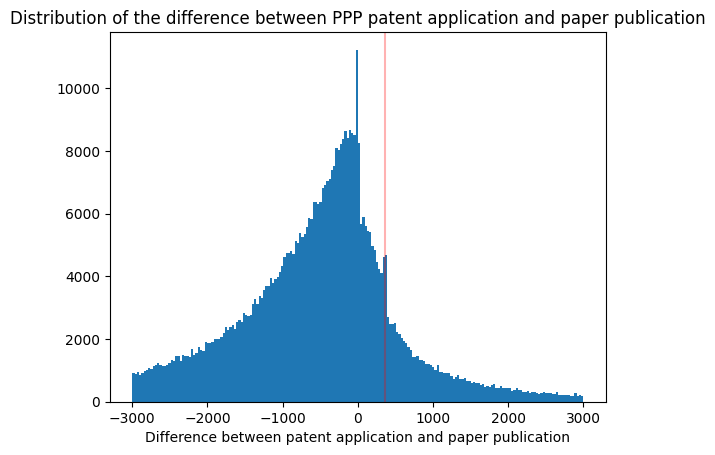

In [15]:
import matplotlib.pyplot as plt

PPPs[PPPs["PPP_score"] >0]["difference_original_patent_app_paper"].hist(bins = 200)
plt.axvline(x = 367 , color = "red", alpha=0.3)
plt.grid()
plt.title("Distribution of the difference between PPP patent application and paper publication")
plt.xlabel("Difference between patent application and paper publication")
plt.show()
